<a href="https://colab.research.google.com/github/Radhibomma/GCollab/blob/main/pixelcnn_md.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👾 PixelCNN using Tensorflow distributions

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
def showimages(images, figsize, grid_size, ran):
    fig = plt.figure(figsize=(figsize, figsize))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(ran):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.axis("off")
        ax.imshow(images[i, :, :], cmap="Greys")

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

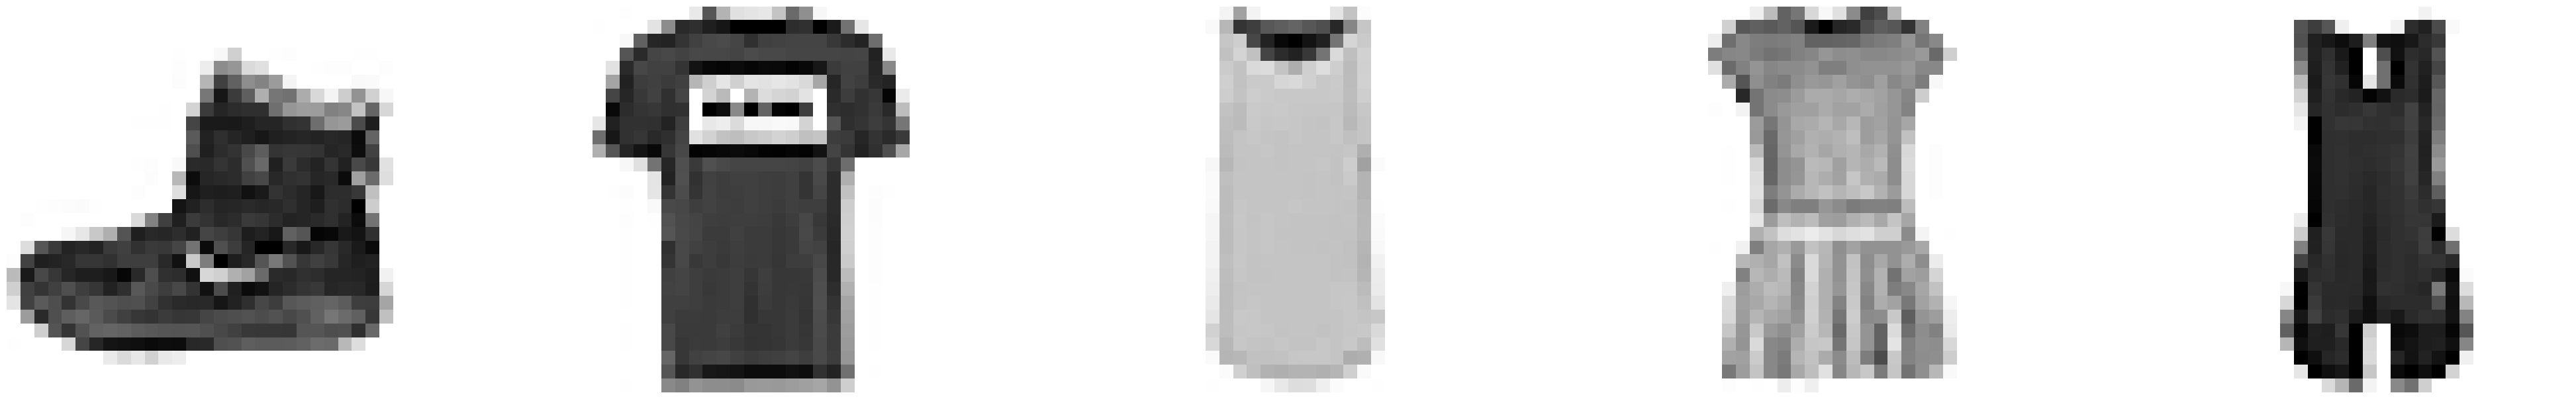

In [ ]:
showimages(x_train, 50, 5, 5)

In [ ]:
# Preprocess the data


def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

In [ ]:
# Show some items of clothing from the training set
display(input_data)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## 2. Build the PixelCNN <a name="build"></a>

In [ ]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

class LogProbLayer(layers.Layer):
    def __init__(self, dist, **kwargs):
        super(LogProbLayer, self).__init__(**kwargs)
        self.dist = dist

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs):
        # Now 'inputs' will be a regular TensorFlow tensor during execution
        return self.dist.log_prob(inputs)

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Create an instance of the custom layer
log_prob_layer = LogProbLayer(dist)

# Define the log likelihood for the loss fn
log_prob = log_prob_layer(image_input)

# Define a custom training step
def custom_train_step(data):
    with tf.GradientTape() as tape:
        # Forward pass
        log_prob_output = pixelcnn(data)
        # Calculate the negative log-likelihood as the loss
        # Clip the log probability output to avoid potential infinities
        log_prob_output = tf.clip_by_value(log_prob_output, -1e6, 1e6)
        # Replace None and NaN with a large negative number
        log_prob_output = tf.where(tf.math.is_nan(log_prob_output), tf.constant(-1e6, dtype=log_prob_output.dtype), log_prob_output)
        log_prob_output = tf.where(tf.math.is_inf(log_prob_output), tf.constant(-1e6, dtype=log_prob_output.dtype), log_prob_output)
        loss = -tf.reduce_mean(log_prob_output)

    # Calculate gradients
    gradients = tape.gradient(loss, pixelcnn.trainable_variables)
    # Update model weights
    pixelcnn.optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))
    return loss

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
#pixelcnn.add_loss(-tf.reduce_mean(log_prob))
#pixelcnn.compile(loss='mse', optimizer='adam')

## 3. Train the PixelCNN <a name="train"></a>

In [ ]:
# Define a custom loss function to handle potential None, NaN, and Inf values
def custom_loss(y_true, y_pred):
    # Clip y_pred to avoid potential infinities or NaNs
    y_pred = tf.clip_by_value(y_pred, -1e6, 1e6)
    # Replace None, NaN, and Inf values with a large negative number
    y_pred = tf.where(tf.math.is_nan(y_pred), tf.constant(-1e6, dtype=y_pred.dtype), y_pred)
    y_pred = tf.where(tf.math.is_inf(y_pred), tf.constant(-1e6, dtype=y_pred.dtype), y_pred)
    y_pred = tf.where(tf.math.is_none(y_pred), tf.constant(-1e6, dtype=y_pred.dtype), y_pred) # added to handle potential None values

    # Calculate and return the loss (negative log-likelihood)
    loss = -tf.reduce_mean(y_pred)
    return loss  # Explicitly return the loss value

pixelcnn.compile(
    loss="mean_squared_error",
    optimizer = "adam",
)

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        # Check if dist.sample returns None and handle it
        samples = dist.sample(self.num_img)
        if samples is None:
            # Handle the case where dist.sample returns None
            # For example, you could return an array of zeros:
            return tf.zeros([self.num_img, 32, 32, 1], dtype=tf.float32).numpy()  # Assuming your image shape
            # Or raise an exception:
            # raise ValueError("dist.sample returned None")
        return samples.numpy()

    def get_config(self):
        config = super().get_config()
        return config

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        #display(
        #    generated_images,
        #    n=self.num_img,
        #    save_to="./output/generated_img_%03d.png" % (epoch),
        #)


img_generator_callback = ImageGenerator(num_img=2)

In [ ]:
pixelcnn.fit(
    input_data, input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


469/469 ━━━━━━━━━━━━━━━━━━━━ 1753s 4s/step - loss: 18851480.0000


## 4. Generate images <a name="generate"></a>

In [ ]:
generated_images = img_generator_callback.generate()

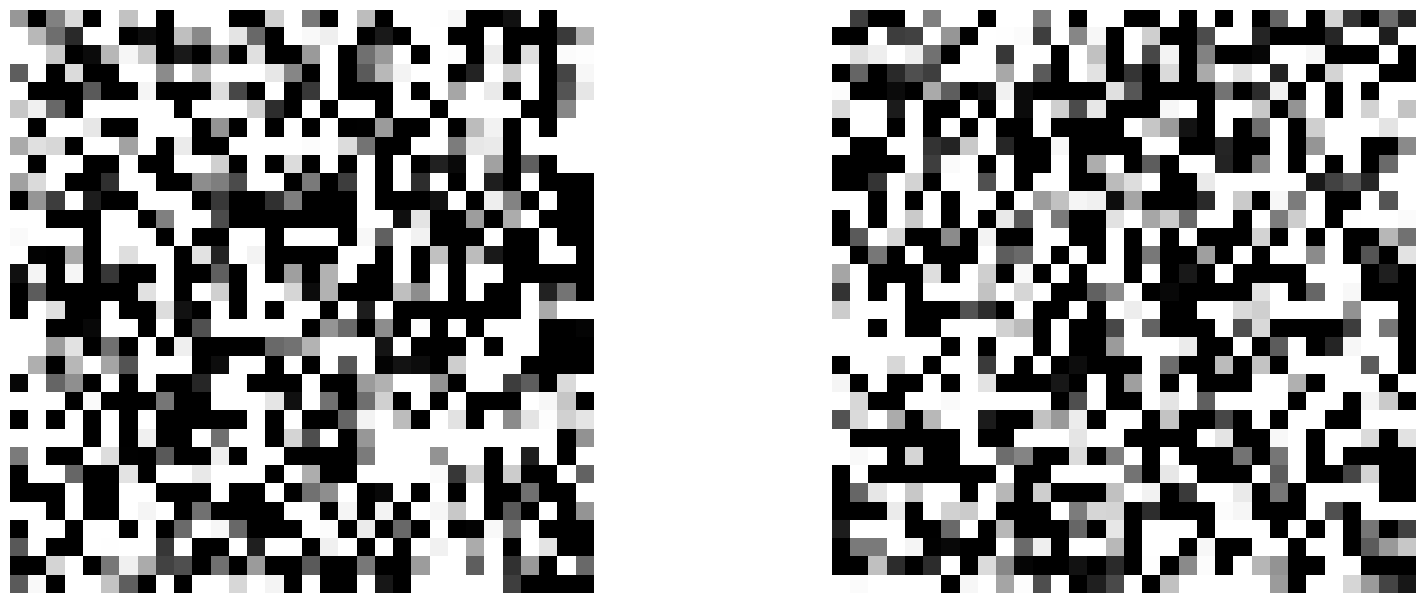

In [ ]:
#display(generated_images, n=img_generator_callback.num_img)
showimages(generated_images, 50, 5, 2)